In [37]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 5)

plt.rcParams['font.family'] = 'Arial'

In [38]:
from sklearn.preprocessing import MinMaxScaler

# Data

In [39]:
nsf=pd.read_csv(r'Data\ProposalFund_NSF.csv',index_col=0)
nsf_gdp=pd.read_csv(r'Data\LocalGDP_NSF.csv',index_col=0)

nsfc=pd.read_csv(r'Data\ProposalFund_NSFC.csv',index_col=0)
nsfc_gdp=pd.read_csv(r'Data\LocalGDP_NSFC.csv',index_col=0)

# Visualization

### ***regression***

In [40]:
nsf_fund=nsf.groupby(['County'])['Funds_MDollars'].sum().reset_index(name='grant')

fusion_nsf=pd.merge(nsf_fund,nsf_gdp,on='County')
fusion_nsf.columns=['unit','grant','gdp']

scaler = MinMaxScaler()

fusion_nsf['grant_1'] = scaler.fit_transform(fusion_nsf[['grant']])
fusion_nsf['gdp_1'] = scaler.fit_transform(fusion_nsf[['gdp']])

fusion_nsf['source']='NSF'

nsfc_fund=nsfc.groupby(['City'])['Funds_MDollars'].sum().reset_index(name='grant')

fusion_nsfc=pd.merge(nsfc_fund,nsfc_gdp,on='City')
fusion_nsfc.columns=['unit','grant','gdp']

scaler = MinMaxScaler()

fusion_nsfc['grant_1'] = scaler.fit_transform(fusion_nsfc[['grant']])
fusion_nsfc['gdp_1'] = scaler.fit_transform(fusion_nsfc[['gdp']])

fusion_nsfc['source']='NSFC'

fusion_both=pd.concat([fusion_nsf,fusion_nsfc])
fusion_both=fusion_both.reset_index(drop=True)
fusion_both

,unit,grant,gdp,grant_1,gdp_1,source
0,"Alachua, Florida",3.649769,18033.00,0.393397,0.015489,NSF
1,"Alameda, California",0.149974,220300.00,0.010946,0.209677,NSF
...,...,...,...,...,...,...
116,Yiyang,0.088732,1792.46,0.013437,0.009302,NSFC
117,Zhengzhou,0.422535,11590.00,0.089260,0.277471,NSFC


In [41]:
import importlib

import my_utils
importlib.reload(my_utils)

from my_utils import mapping_dict

import seaborn as sns
from scipy import stats
import re
from matplotlib.lines import Line2D
from adjustText import adjust_text

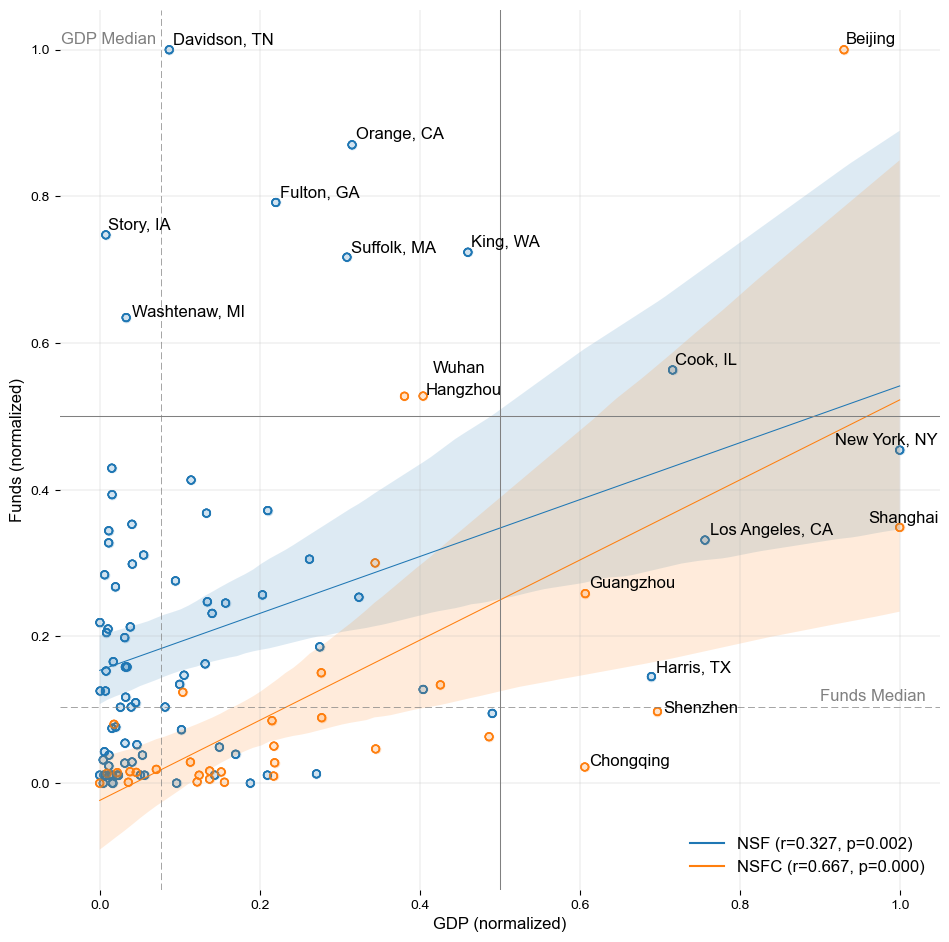

In [42]:
palette = {'NSF': '#1f77b4', 'NSFC': '#ff7f0e'}

fig, ax1 = plt.subplots(figsize=(11, 11)) 

for source, clusters in zip(['NSF', 'NSFC'], [[0, 1, 2, 3], [0, 1, 2]]):
    for cluster in clusters:

        data = fusion_both[fusion_both['source'] == source]
        
        facecolor = palette[source] if cluster == 0 else 'none' 

        ax1.scatter(
            data['gdp_1'], 
            data['grant_1'], 
            label=f'{source} Cluster {cluster} {len(data)}/{len(fusion_both[fusion_both["source"] == source])}', 
            edgecolor=palette[source], 
            facecolor='none',  
            marker='o',  
            s=30 
        )

legend_elements = [] 
for source in ['NSF', 'NSFC']:
    data_source = fusion_both[fusion_both['source'] == source]

    sns.regplot(
        x='gdp_1', 
        y='grant_1', 
        data=data_source, 
        scatter=True, 
        ax=ax1, 
        color=palette[source], 
        label=None, 
        line_kws={'linewidth': 0.75,
                  'alpha':1}, 
        ci=95,
        scatter_kws={'alpha': 0.2}
    )

    slope, intercept, r_value, p_value, std_err = stats.linregress(data_source['gdp_1'], data_source['grant_1'])

    legend_elements.append(Line2D([0], [0], color=palette[source], label=f'{source} (r={r_value:.3f}, p={p_value:.3f})'))

ax1.axhline(0.5, color='gray', linewidth=0.75) 
ax1.axvline(0.5, color='gray', linewidth=0.75) 

gdp_median = fusion_both['gdp_1'].median()
grant_median = fusion_both['grant_1'].median()

ax1.axhline(grant_median, color='gray', linestyle='--', linewidth=0.5, dashes=(10, 5)) 
ax1.axvline(gdp_median, color='gray', linestyle='--', linewidth=0.5, dashes=(10, 5))  

ax1.text(gdp_median-0.065, ax1.get_ylim()[1]-0.05, 'GDP Median', fontsize=12, color='gray', ha='center', va='bottom')  
ax1.text(ax1.get_xlim()[1]-0.15, grant_median+0.015, 'Funds Median', fontsize=12, color='gray', va='center', ha='left')  

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax1.set_xlabel('GDP (normalized)', fontsize=12)
ax1.set_ylabel('Funds (normalized)', fontsize=12)

ax1.legend(handles=legend_elements, loc='lower right', fontsize=12, frameon=False)

ax1.tick_params(left=True, bottom=True)
ax1.tick_params(axis='both', which='major', labelsize=10)

texts = []

for i, row in fusion_both.iterrows():
    if row['gdp_1'] > 0.5 or row['grant_1'] > 0.5:
        clean_unit = re.sub(r'(?i)\s*county', '', row['unit']).strip()
        
        if clean_unit in mapping_dict:
            clean_unit = mapping_dict[clean_unit]
        
        text = ax1.text(row['gdp_1'], row['grant_1'], clean_unit, fontsize=12, color='black', ha='left')
        texts.append(text)

adjust_text(texts)

plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.grid(linewidth=0.2)

plt.savefig(r'Figure\Figure_3_new.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.savefig(r'Figure\Figure_3_new.png', format='png', dpi=600, bbox_inches='tight')

plt.show()

### ***gini***

In [43]:
import importlib

import my_utils
importlib.reload(my_utils)

from my_utils import gini_coefficient

### NSF

In [44]:
years = sorted(nsf['Year'].unique())

results = []
for year in years:
    previous_data = nsf[nsf['Year'] <= year]
    city_funding = previous_data.groupby('County')['Funds_MDollars'].sum().reset_index()
    city_funding = city_funding.merge(nsf_gdp, on='County', how='left')
    results.append(city_funding[['County', 'Funds_MDollars', 'gdp']].values.tolist())

results_update=[]
for i in range(len(results)):
    updated_data = [[f'{i+2017}', item[0], item[1], item[2]] for item in results[i]]
    results_update.extend(updated_data)

results_df=pd.DataFrame(results_update)
results_df.columns=['year','unit','total_funds_till_this_year','gdp']
results_df['source']='NSF'

results_df_pivot_nsf = results_df.pivot_table(index='unit', columns='year', values='total_funds_till_this_year')
results_df_pivot_nsf = results_df_pivot_nsf.reset_index(drop=False)

city_names = set()
for year_data in results:
    for city_data in year_data:
        city_names.add(city_data[0])
city_names = sorted(list(city_names))

city_funding = {city: [0] * len(years) for city in city_names}

for year_idx, year_data in enumerate(results):
    for city_data in year_data:
        city_funding[city_data[0]][year_idx] = city_data[1]

gini_coefficients_nsf = []
for year_idx in range(len(years)):
    funding_for_year = [
        city_funding[city][year_idx] 
        for city in city_names 
        if city_funding[city][year_idx] > 0
    ]
    gini = gini_coefficient(funding_for_year)
    gini_coefficients_nsf.append(gini)

### NSFC

In [45]:
years = sorted(nsfc['Year'].unique())

results_nsfc = []
for year in years:
    previous_data = nsfc[nsfc['Year'] <= year]
    city_funding = previous_data.groupby('City')['Funds_MDollars'].sum().reset_index()    
    results_nsfc.append(city_funding[['City', 'Funds_MDollars']].values.tolist())

for sublist in results_nsfc:
    for entry in sublist:
        city = entry[0]
        gdp_value = nsfc_gdp.loc[nsfc_gdp['City'] == city, 'gdp'].values
        if gdp_value.size > 0:
            entry.append(gdp_value[0])

results_update=[]
for i in range(len(results_nsfc)):
    updated_data = [[f'{i+2015}', item[0], item[1], item[2]] for item in results_nsfc[i]]
    results_update.extend(updated_data)

results_nsfc_df=pd.DataFrame(results_update)
results_nsfc_df.columns=['year','unit','total_funds_till_this_year','gdp']
results_nsfc_df['source']='NSFC'

results_df_pivot_nsfc = results_nsfc_df.pivot_table(index='unit', columns='year', values='total_funds_till_this_year')
results_df_pivot_nsfc = results_df_pivot_nsfc.reset_index(drop=False)

city_names = set()
for year_data in results_nsfc:
    for city_data in year_data:
        city_names.add(city_data[0])
city_names = sorted(list(city_names))

city_funding = {city: [0] * len(years) for city in city_names}

for year_idx, year_data in enumerate(results_nsfc):
    for city_data in year_data:
        city_funding[city_data[0]][year_idx] = city_data[1]

gini_coefficients_nsfc = []
for year_idx in range(len(years)):
    funding_for_year = [
        city_funding[city][year_idx] 
        for city in city_names 
        if city_funding[city][year_idx] > 0
    ]
    gini = gini_coefficient(funding_for_year)
    gini_coefficients_nsfc.append(gini)

### GINI

In [46]:
gini_coefficients_nsf

[0.4322241749402547,
 0.3992559545998893,
 0.3842480963602073,
 0.429343953023227,
 0.4718704050465173,
 0.525291507325219,
 0.5412106506604798]

In [47]:
gini_coefficients_nsfc

[0.013888888888888952,
 0.4927861617751444,
 0.6404275570138638,
 0.6457945854591489,
 0.6623946834271881,
 0.6621501103693372]

# plot

In [48]:
scaler = MinMaxScaler()

df_nsf_gdp=results_df.drop_duplicates(subset='unit')
df_nsf_gdp=df_nsf_gdp[['unit','gdp']]
df_nsf_gdp['gdp_normalized'] = scaler.fit_transform(df_nsf_gdp[['gdp']])

df_nsfc_gdp=results_nsfc_df.drop_duplicates(subset='unit')
df_nsfc_gdp=df_nsfc_gdp[['unit','gdp']]
df_nsfc_gdp['gdp_normalized'] = scaler.fit_transform(df_nsfc_gdp[['gdp']])

In [49]:
results_df_pivot=results_df_pivot_nsf.copy()
results_df_nsfc_pivot=results_df_pivot_nsfc.copy()

merged_df_nsf = results_df_pivot.merge(df_nsf_gdp[['unit', 'gdp_normalized']], on='unit')
merged_df_nsf.set_index('unit', inplace=True)
results_df_pivot = merged_df_nsf.drop(columns='gdp_normalized').transpose()
gdp_normalized_nsf = merged_df_nsf['gdp_normalized']
top_5_nsf = gdp_normalized_nsf.nlargest(6).index



merged_df_nsfc = results_df_nsfc_pivot.merge(df_nsfc_gdp[['unit', 'gdp_normalized']], on='unit')
merged_df_nsfc.set_index('unit', inplace=True)
results_df_nsfc_pivot = merged_df_nsfc.drop(columns='gdp_normalized').transpose()
gdp_normalized_nsfc = merged_df_nsfc['gdp_normalized']
top_5_nsfc = gdp_normalized_nsfc.nlargest(6).index

In [50]:
from adjustText import adjust_text
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap

cmap_left = LinearSegmentedColormap.from_list("gray_to_blue", ["#e0e0e0", "#1f77b4"]) 
cmap_right = LinearSegmentedColormap.from_list("gray_to_orange", ["#e0e0e0", "#ff7f0e"]) 

C:\Users\lenovo\AppData\Local\Temp\ipykernel_23220\2537022349.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


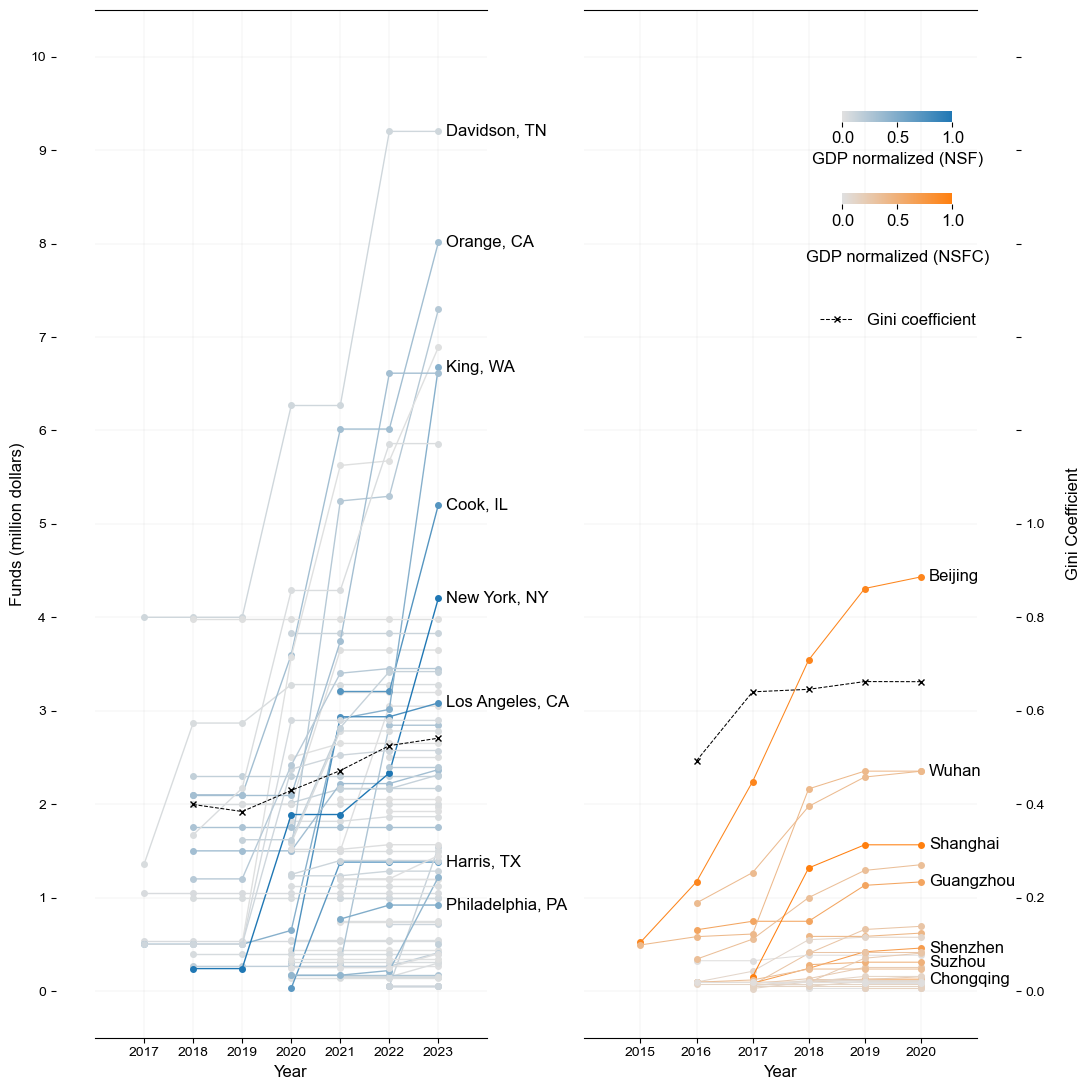

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(11, 11))

results_df_pivot.index = results_df_pivot.index.astype(int)

texts_nsf = [] 
gini_coefficients_nsf_neg = [value * 5 for value in gini_coefficients_nsf]

for i, unit in enumerate(results_df_pivot.columns):
    alpha_value = gdp_normalized_nsf[unit] 
    color_value = cmap_left(gdp_normalized_nsf[unit])
    axes[0].plot(results_df_pivot.index, results_df_pivot[unit], 
                 marker='o', label=unit, linewidth=1, markersize=4, 
                 color=color_value)

    if unit in top_5_nsf or results_df_pivot[unit].values[-1] in sorted(results_df_pivot.iloc[-1], reverse=True)[:2]:
        mapped_unit = mapping_dict.get(unit, unit)
        text = axes[0].text(2023.15, results_df_pivot[unit].values[-1], mapped_unit, 
                            fontsize=12, ha='left', va='center')
        texts_nsf.append(text)


axes[0].plot(results_df_pivot.index[1:], gini_coefficients_nsf_neg[1:], 
             marker='x', linestyle='--', color='k', 
             label='Gini Coefficient (Negative)', linewidth=0.75, markersize=5)

'''adjust_text(texts_nsf, ax=axes[0], only_move={'points': 'y', 'text': 'y'}, 
            arrowprops=dict(arrowstyle="-", color='k', lw=0.5))'''

axes[0].set_xlim(2016, 2024)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].set_ylim(-0.5, 10.5)
axes[0].set_xticks(results_df_pivot.index)
axes[0].set_xticklabels(results_df_pivot.index, fontsize=10)
axes[0].set_ylabel('Funds (million dollars)', fontsize=12)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_yticks(range(0, 11)) 
axes[0].set_yticklabels(range(0, 11))
axes[0].tick_params(axis='y', labelsize=10)  # 设置左y轴刻度字体大小为8
axes[0].grid(linewidth=0.1)
axes[0].spines['left'].set_position(('axes', -0.1))  # 相对于图形宽度的 105% 处



results_df_nsfc_pivot.index = results_df_nsfc_pivot.index.astype(int)
gini_coefficients_nsfc_neg = [value * 5 for value in gini_coefficients_nsfc]

texts_nsfc = []

for i, unit in enumerate(results_df_nsfc_pivot.columns):
    alpha_value = gdp_normalized_nsfc[unit] 
    color_value = cmap_right(gdp_normalized_nsfc[unit]) 
    axes[1].plot(results_df_nsfc_pivot.index, results_df_nsfc_pivot[unit], 
                 marker='o', label=unit, linewidth=0.75, markersize=4, 
                 color=color_value, 
                 )

    if unit in top_5_nsfc or results_df_nsfc_pivot[unit].values[-1] in sorted(results_df_nsfc_pivot.iloc[-1], reverse=True)[:2]:
        text = axes[1].text(2020.15, results_df_nsfc_pivot[unit].values[-1], unit, 
                            fontsize=12, ha='left', va='center')
        texts_nsfc.append(text)

axes[1].plot(results_df_nsfc_pivot.index[1:], gini_coefficients_nsfc_neg[1:], 
             marker='x', linestyle='--', color='k', 
             label='Gini Coefficient', linewidth=0.75, markersize=5)

'''adjust_text(texts_nsfc, ax=axes[1], only_move={'points': 'y', 'text': 'y'}, 
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))'''

axes[1].set_xlim(2014, 2021)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].set_ylim(-0.5, 10.5)
axes[1].set_xticks(results_df_nsfc_pivot.index)
axes[1].set_xticklabels(results_df_nsfc_pivot.index, fontsize=10)
axes[1].set_yticks(range(0, 11))  
axes[1].set_yticklabels([], fontsize=10)  
axes[1].set_xlabel('Year', fontsize=12)
axes[1].grid(linewidth=0.1)

left_yticks = axes[0].get_yticks() 
left_yticks = list(map(float, left_yticks)) 
right_yticks = [tick / 5 for tick in left_yticks] 

axes[1].set_yticks(left_yticks)

#axes[1].set_yticklabels([f'{i}' for i in right_yticks])
axes[1].set_yticklabels([f'{i:.1f}' if i <= 1 else '' for i in right_yticks])

axes[1].tick_params(axis='y', labelsize=10)  # 设置左y轴刻度字体大小为8
axes[1].set_ylabel('Gini Coefficient', fontsize=12, labelpad=15)
axes[1].yaxis.tick_right()  
axes[1].yaxis.set_label_position("right") 
axes[1].spines['right'].set_position(('axes', 1.1))  # 相对于图形宽度的 105% 处

legend_marker = Line2D([], [], color='k', marker='x', linestyle='--', markersize=5, label='Gini coefficient',linewidth=0.75)
legend = axes[1].legend(handles=[legend_marker], fontsize=12, frameon=False)
legend.set_bbox_to_anchor([0.935, 0.71, 0.1, 0.01])

cbar_ax = fig.add_axes([0.77, 0.885, 0.1, 0.01])  
norm_left = mpl.colors.Normalize(vmin=gdp_normalized_nsf.min(), vmax=gdp_normalized_nsf.max())
cb_left = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap_left, norm=norm_left, orientation='horizontal', ticklocation='bottom')  
cb_left.outline.set_visible(False)  
cb_left.set_label('GDP normalized (NSF)', fontsize=12) 
cb_left.ax.tick_params(labelsize=12)

cbar_ax_right = fig.add_axes([0.77, 0.81, 0.1, 0.01])  
norm_right = mpl.colors.Normalize(vmin=gdp_normalized_nsfc.min(), vmax=gdp_normalized_nsfc.max())
cb_right = mpl.colorbar.ColorbarBase(cbar_ax_right, cmap=cmap_right, norm=norm_right, orientation='horizontal', ticklocation='bottom')  
cb_right.outline.set_visible(False)  
cb_right.set_label('GDP normalized (NSFC)', fontsize=12, labelpad=15) 
cb_right.ax.tick_params(labelsize=12)

plt.tight_layout()

plt.savefig(r'Figure\Figure_4_new.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.savefig(r'Figure\Figure_4_new.png', format='png', dpi=600, bbox_inches='tight')

plt.show()